# Dijkstra algorithm for sparse graphs

Implement the refined Dijkstra algorithm from the paper [An improved Dijkstra’s shortest path algorithm for sparse network](https://www.sciencedirect.com/science/article/abs/pii/S0096300306008563). Check if its performance is faster than the simple heapq Dijkstra 

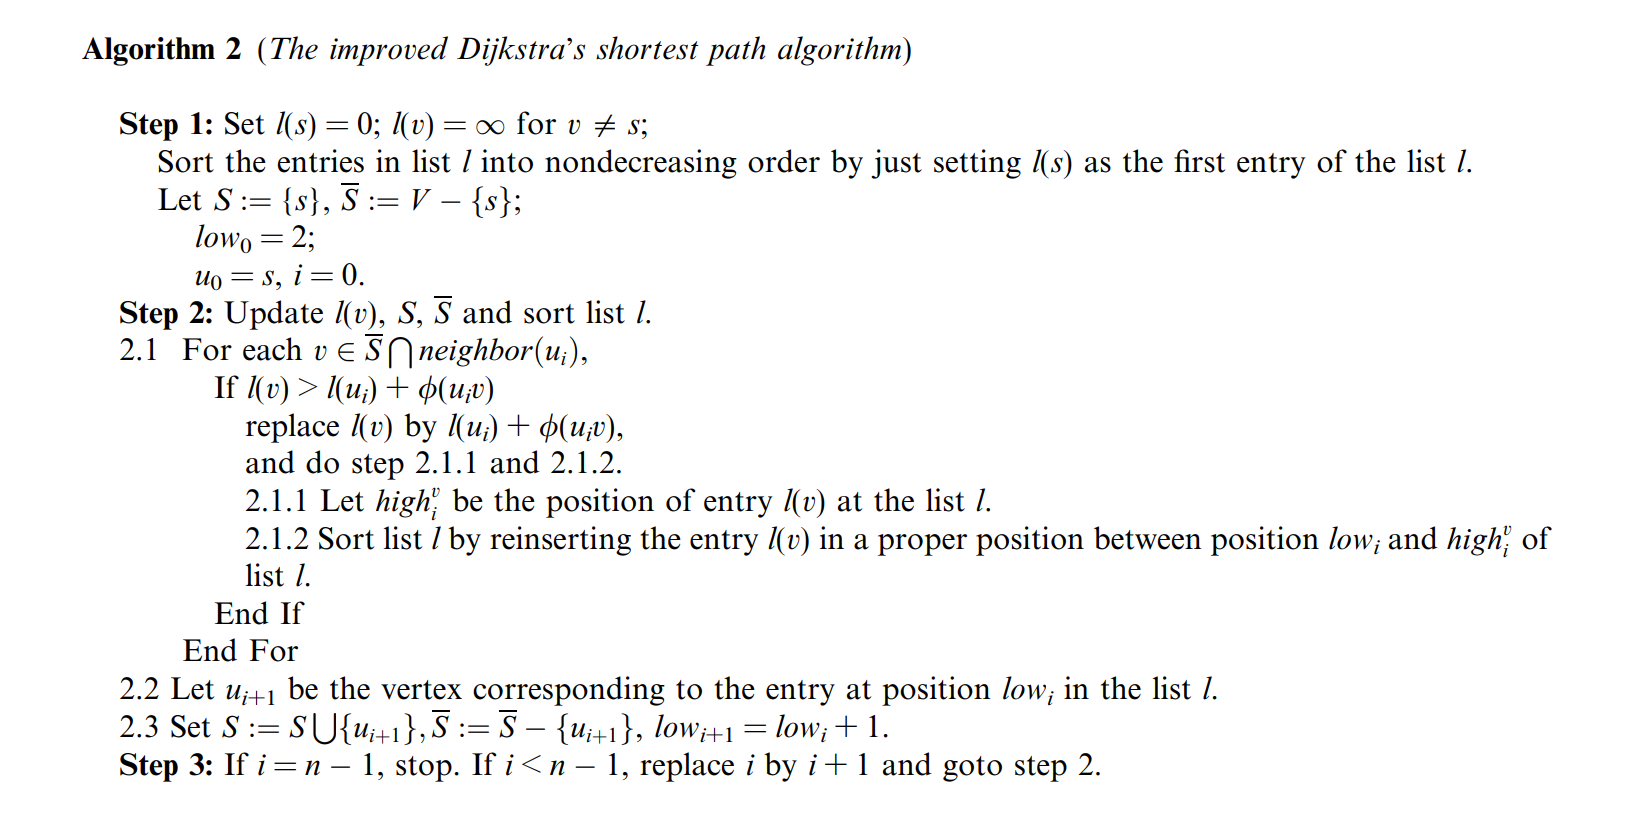

The core change is in the handling of the list of $l(\cdot)$'s of tentative distances. Instead of using a heap data structure and the likes: for the extracting of the minimum distance, insertion/updates of tentative distances, and maintaining the sorted order of the list, we make use of a different method for the insertion of the new distance $l(\cdot)$ and where to insert it into the list (refer to $2.1.2$); in short, the data structure of the queue and the maintenance of its sorted order

- $2.1.2)$ Sort list $l$ by reinserting the entry $l(v)$ in a proper position between position $low_i$ and $high_i^v$ of list $l$

So for each iteration it just takes the next position from the list as the minimum: since the sorting of the list is handled by the previous two process of properly reinserting the entry $l(v)$ and upholding the order of the list

The core idea of $2.1.2$ is using a binary search between the length of $low_i$ and $high_i^v$ to determine where to put the tentative distance $l(v)$ since the sublist across this length is nondecreasing. Traditionally binary search divides the length to find the midpoint, but here we incorporate a step size vector which gives the midpoint for each length (avoiding division) in the binary search

In [1]:
# Heap implementation
import heapq


def dijkstra_heap(G, source, target):
    visited = set()
    queue = [(0, source, None)]  # (tentative cost, vertex, parent)
    parents = {}
    
    while queue:
        vertex_cost, vertex, parent = heapq.heappop(queue)  # Get lowest cost vertex from the queue

        if vertex in visited:
            continue

        visited.add(vertex) # Consider vertex as visited
        parents[vertex] = parent
        
        # End algorithm when vertex visited is the goal node
        if vertex == target:
            break

        # Relax neighbor vertices of vertex
        for _, neighbor, edge_length in G.out_edges(vertex, data="length"):
            if neighbor in visited:
                continue

            # No need to check if new cost is an improvement, just add it to the queue; other costs will be disregarded later on
            neighbor_cost = vertex_cost + edge_length 
            heapq.heappush(queue, (neighbor_cost, neighbor, vertex))

    return parents

The structure of the code, I think, will still closely follow the heap implemenetation previously. But the popping and inserting of vertices will be totally different (and also the data structures used). I think it would be beneficial to also try to retain the efficiency quirks of the heap implementation: not adding all the vertices from the start; multiple costs for same vertices existing in the queue. But not sure if they would apply

One issue I'm seeing is that we'd have to find a way of getting the position of the vertex in the list. Suppose that we successfully implement the data structure replacing the heap process; but the introduction of $O(n)$ searches might make the performance all the same if not worse

**Will skip implementation for now, not worth it**

# Working implementation, bad performance will finally drop it

No efficient way of finding the node's position in the queue (runs linearly) and hence the bad performance. Could have used a binary heap for the queue, but then what's the difference with the simple `heapq` implementation: essentially just changed the `heappush` with a binary search, and `heapppop` with just a front `pop` since the queue is now always linearly ordered 

In [ ]:
import osmnx as ox
import time

G = ox.io.load_graphml(filepath="metro_drive.graphml")
weight = "length"

def create_step_size(n):
    step_size = [0] * n
    i, j = 1, 0
    while i < n - 1:
        j += 1
        step_size[i] = j
        i += 1
        step_size[i] = j
        i += 1
    if i == n - 1:
        j += 1
        step_size[i] = j
    return step_size

def process_2(Entry, low, high, value):
    bottom = low
    top = high - 1
    if value >= Entry[top][0]:
        return high
    else:
        length = top - bottom
        while length > 1:
            mid = bottom + step_size[length]
            
            if value < Entry[mid][0]:
                top = mid
            else:
                bottom = mid
            
            length = top - bottom
        
        if value < Entry[bottom][0]:
            location = bottom
        else:
            location = top
    return location

def dijkstra(G, source, target):
    visited = set()
    queue = [(0, source, None)]  # (tentative cost, vertex, parent)
    parents = {}

    for node in list(G.nodes):
        if (node == source):
            continue
        
        queue.append((float("inf"), node, None))

    while queue:
        vertex_cost, vertex, parent = queue.pop(0)  # Get lowest cost vertex from the front of the queue
        if vertex in visited:
            continue

        visited.add(vertex)  # Consider vertex as visited
        parents[vertex] = parent
        
        # End algorithm when vertex visited is the goal node
        if vertex == target:
            break

        # Relax neighbor vertices of vertex
        for _, neighbor, edge_length in G.out_edges(vertex, data="length"):
            if neighbor in visited:
                continue

            neighbor_cost = vertex_cost + edge_length

            # Find position in list
            current_pos = next(i for i, (_, n, _) in enumerate(queue) if n == neighbor)
            node = queue[current_pos]

            # Test that current_pos actually matches the node we're trying to find
            if (queue[current_pos][1] != neighbor):
                print("Position calculated does not contain the desired node")

            # Relax
            if (node[0] > neighbor_cost):
                # Find the correct position to insert the new entry
                insert_pos = process_2(queue, 0, current_pos, neighbor_cost)

                queue.pop(current_pos)

                # Make new tuple with updated cost and insert
                new_tuple = (neighbor_cost, neighbor, vertex)
                queue.insert(insert_pos, new_tuple)
            

    return parents

# Reconstruct the path
def make_path(parent, target):
    if target not in parent:
        return None
    
    v = target
    path = []
    while v is not None: # root has null parent
        path.append(v)
        v = parent[v]
    return path[::-1]

# Create a global step_size list
step_size = create_step_size(60000)  # Adjust size as needed

# Test points
source = ox.nearest_nodes(G, 120.99169, 14.51015)
target = ox.nearest_nodes(G, 121.0643, 14.6548)

#source, target = 1278924698, 6997882512

# Run Dijkstra
start = time.perf_counter() 

result = dijkstra(G, source, target)

end = time.perf_counter() 
execution_time = end - start

print("Program Executed in " + str(execution_time)) # It returns time in seconds

assert make_path(result, target) == ox.shortest_path(G, source, target), f"Path is not the same"